Article: TBA\
Code: Customer Sales Prediction using Linear Regression, Random Forest, XG Boost, and LSTM\
Dataset Link: https://www.kaggle.com/competitions/demand-forecasting-kernels-only/data?select=train.csv\
Prepared By: Awais Naeem (awais.naeem@embedded-robotics.com)\
Copyrights: www.embedded-robotics.com\
Disclaimer: This code can be distributed with the proper mention of the owner copyrights

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
store_sales = pd.read_csv('store_sale.csv')
store_sales.head(10)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
5,2013-01-06,1,1,12
6,2013-01-07,1,1,10
7,2013-01-08,1,1,9
8,2013-01-09,1,1,12
9,2013-01-10,1,1,9


In [3]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [4]:
store_sales = store_sales.drop(['store','item'], axis=1)

In [5]:
store_sales['date'] = pd.to_datetime(store_sales['date'])

In [6]:
store_sales['date'] = store_sales['date'].dt.to_period('M')
monthly_sales = store_sales.groupby('date').sum().reset_index()

In [7]:
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()
monthly_sales.head(10)

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242
5,2013-06-01,795597
6,2013-07-01,855922
7,2013-08-01,766761
8,2013-09-01,689907
9,2013-10-01,656587


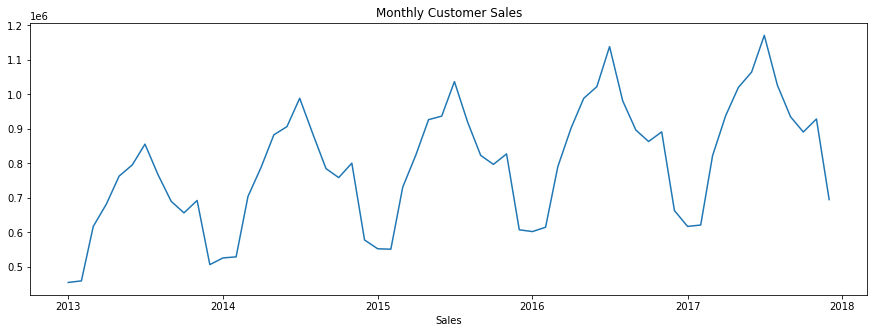

In [8]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.xlabel('Date')
plt.xlabel('Sales')
plt.title("Monthly Customer Sales")
plt.show()

In [9]:
monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
monthly_sales = monthly_sales.dropna()
monthly_sales.head(10)

,date,sales,sales_diff
1,2013-02-01,459417,4513.0
2,2013-03-01,617382,157965.0
3,2013-04-01,682274,64892.0
4,2013-05-01,763242,80968.0
5,2013-06-01,795597,32355.0
6,2013-07-01,855922,60325.0
7,2013-08-01,766761,-89161.0
8,2013-09-01,689907,-76854.0
9,2013-10-01,656587,-33320.0
10,2013-11-01,692643,36056.0


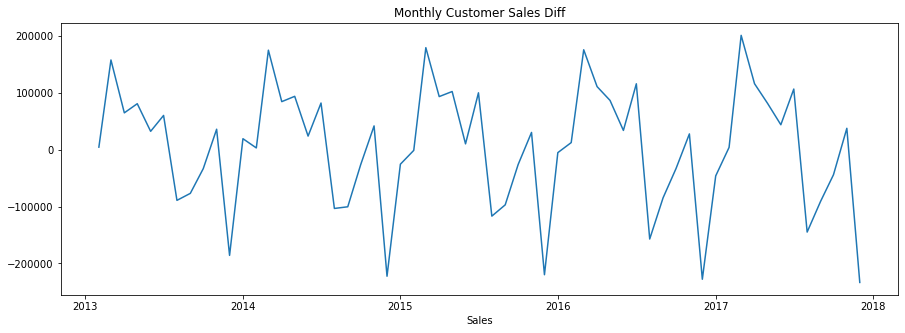

In [10]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales_diff'])
plt.xlabel('Date')
plt.xlabel('Sales')
plt.title("Monthly Customer Sales Diff")
plt.show()

In [11]:
supverised_data = monthly_sales.drop(['date','sales'], axis=1)

In [12]:
for i in range(1,13):
    col_name = 'month_' + str(i)
    supverised_data[col_name] = supverised_data['sales_diff'].shift(i)

In [13]:
supverised_data = supverised_data.dropna().reset_index(drop=True)
supverised_data.head(10)

,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0
5,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0
6,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0
7,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0
8,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0
9,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0


In [14]:
train_data = supverised_data[:-12]
test_data = supverised_data[-12:]
print('Train Data Shape:', train_data.shape)
print('Test Data Shape:', test_data.shape)

Train Data Shape: (35, 13)
Test Data Shape: (12, 13)


In [15]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)

MinMaxScaler(feature_range=(-1, 1))

In [16]:
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [49]:
X_train, y_train = train_data[:,1:], train_data[:,0:1]
X_test, y_test = test_data[:,1:], test_data[:,0:1]
y_train = y_train.ravel()
y_test = y_test.ravel()
print('X_train Shape:', X_train.shape)
print('y_train Shape:', y_train.shape)
print('X_test Shape:', X_test.shape)
print('y_test Shape:', y_test.shape)


X_train Shape: (35, 12)
y_train Shape: (35,)
X_test Shape: (12, 12)
y_test Shape: (12,)


In [19]:
sales_dates = monthly_sales['date'][-12:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)

In [20]:
act_sales = monthly_sales['sales'][-13:].to_list()

#### Linear Regression

In [21]:
linreg_model = LinearRegression()
linreg_model.fit(X_train, y_train)
linreg_pred = linreg_model.predict(X_test)

In [22]:
linreg_pred = linreg_pred.reshape(-1,1)
linreg_pred_test_set = np.concatenate([linreg_pred,X_test], axis=1)
linreg_pred_test_set = scaler.inverse_transform(linreg_pred_test_set)

In [23]:
result_list = []
for index in range(0, len(linreg_pred_test_set)):
    result_list.append(linreg_pred_test_set[index][0] + act_sales[index])
linreg_pred_series = pd.Series(result_list,name='linreg_pred')
predict_df = predict_df.merge(linreg_pred_series, left_index=True, right_index=True)

In [24]:
linreg_rmse = np.sqrt(mean_squared_error(predict_df['linreg_pred'], monthly_sales['sales'][-12:]))
linreg_mae = mean_absolute_error(predict_df['linreg_pred'], monthly_sales['sales'][-12:])
linreg_r2 = r2_score(predict_df['linreg_pred'], monthly_sales['sales'][-12:])
print('Linear Regression RMSE: ', linreg_rmse)
print('Linear Regression MAE: ', linreg_mae)
print('Linear Regression R2 Score: ', linreg_r2)

Linear Regression RMSE:  16221.272385416856
Linear Regression MAE:  12433.184266490774
Linear Regression R2 Score:  0.9906152516380969


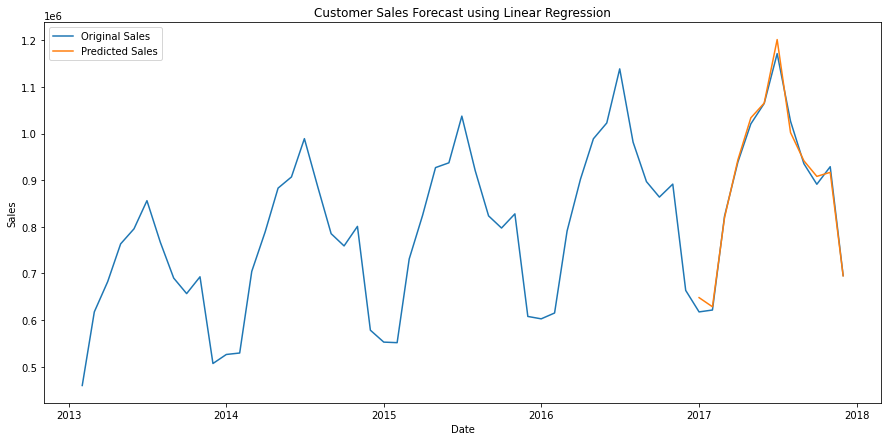

In [25]:
plt.figure(figsize=(15,7))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.plot(predict_df['date'], predict_df['linreg_pred'])
plt.title("Customer Sales Forecast using Linear Regression")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(["Original Sales", "Predicted Sales"])
plt.show()

#### Random Forest

In [26]:
rf_model = RandomForestRegressor(n_estimators=100, max_depth=20)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

In [27]:
rf_pred = rf_pred.reshape(-1,1)
rf_pred_test_set = np.concatenate([rf_pred,X_test], axis=1)
rf_pred_test_set = scaler.inverse_transform(rf_pred_test_set)

In [28]:
result_list = []
for index in range(0, len(rf_pred_test_set)):
    result_list.append(rf_pred_test_set[index][0] + act_sales[index])
rf_pred_series = pd.Series(result_list, name='rf_pred')
predict_df = predict_df.merge(rf_pred_series, left_index=True, right_index=True)

In [29]:
rf_rmse = np.sqrt(mean_squared_error(predict_df['rf_pred'], monthly_sales['sales'][-12:]))
rf_mae = mean_absolute_error(predict_df['rf_pred'], monthly_sales['sales'][-12:])
rf_r2 = r2_score(predict_df['rf_pred'], monthly_sales['sales'][-12:])
print('Random Forest RMSE: ', rf_rmse)
print('Random Forest MAE: ', rf_mae)
print('Random Forest R2 Score: ', rf_r2)

Random Forest RMSE:  17694.87898191384
Random Forest MAE:  14944.624166666696
Random Forest R2 Score:  0.9880636019264113


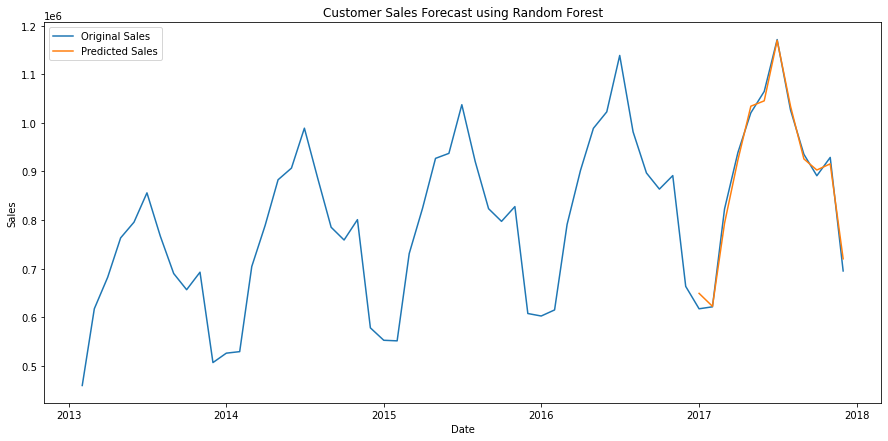

In [30]:
plt.figure(figsize=(15,7))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.plot(predict_df['date'], predict_df['rf_pred'])
plt.title("Customer Sales Forecast using Random Forest")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(["Original Sales", "Predicted Sales"])
plt.show()

#### XG Boost

In [31]:
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.2, objective='reg:squarederror')
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

In [32]:
xgb_pred = xgb_pred.reshape(-1,1)
xgb_pred_test_set = np.concatenate([xgb_pred,X_test], axis=1)
xgb_pred_test_set = scaler.inverse_transform(xgb_pred_test_set)

In [33]:
result_list = []
for index in range(0, len(xgb_pred_test_set)):
    result_list.append(xgb_pred_test_set[index][0] + act_sales[index])
xgb_pred_series = pd.Series(result_list, name='xgb_pred')
predict_df = predict_df.merge(xgb_pred_series, left_index=True, right_index=True)

In [34]:
xgb_rmse = np.sqrt(mean_squared_error(predict_df['xgb_pred'], monthly_sales['sales'][-12:]))
xgb_mae = mean_absolute_error(predict_df['xgb_pred'], monthly_sales['sales'][-12:])
xgb_r2 = r2_score(predict_df['xgb_pred'], monthly_sales['sales'][-12:])
print('XG Boost RMSE: ', xgb_rmse)
print('XG Boost MAE: ', xgb_mae)
print('XG Boost R2 Score: ', xgb_r2)

XG Boost RMSE:  15701.124706426719
XG Boost MAE:  13342.738751299059
XG Boost R2 Score:  0.9907513141349301


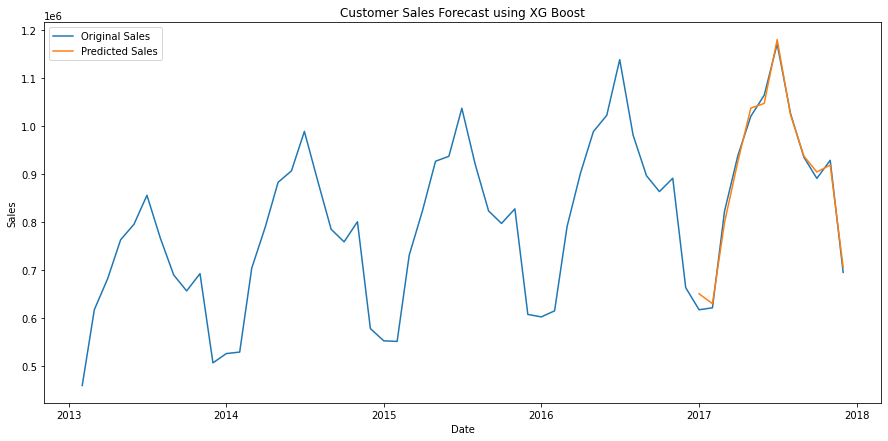

In [35]:
plt.figure(figsize=(15,7))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.plot(predict_df['date'], predict_df['xgb_pred'])
plt.title("Customer Sales Forecast using XG Boost")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(["Original Sales", "Predicted Sales"])
plt.show()

#### LSTM

In [36]:
X_train_lstm = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_lstm = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [37]:
model = Sequential()
model.add(LSTM(4, batch_input_shape=(1, X_train_lstm.shape[1], X_test_lstm.shape[2])))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [38]:
checkpoint_filepath = os.getcwd()
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, monitor='val_loss', mode='min', save_best_only=True)
callbacks = [EarlyStopping(patience=5), model_checkpoint_callback]

In [39]:
history = model.fit(X_train_lstm, y_train, epochs=200, batch_size=1, validation_data=(X_test_lstm, y_test), callbacks=callbacks)

Epoch 1/200
21/35 [=================>............] - ETA: 0s - loss: 0.3297  

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 13s 249ms/step - loss: 0.3073 - val_loss: 0.3337
Epoch 2/200
32/35 [==========================>...] - ETA: 0s - loss: 0.2565

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 6s 190ms/step - loss: 0.2838 - val_loss: 0.3133
Epoch 3/200
16/35 [============>.................] - ETA: 0s - loss: 0.2866

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 9s 252ms/step - loss: 0.2660 - val_loss: 0.2935
Epoch 4/200
27/35 [======================>.......] - ETA: 0s - loss: 0.2526

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 9s 254ms/step - loss: 0.2507 - val_loss: 0.2760
Epoch 5/200
35/35 [==============================] - ETA: 0s - loss: 0.2344

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 8s 236ms/step - loss: 0.2344 - val_loss: 0.2576
Epoch 6/200
30/35 [========================>.....] - ETA: 0s - loss: 0.2035

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 8s 224ms/step - loss: 0.2208 - val_loss: 0.2402
Epoch 7/200
31/35 [=========================>....] - ETA: 0s - loss: 0.2046

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 7s 216ms/step - loss: 0.2048 - val_loss: 0.2247
Epoch 8/200
31/35 [=========================>....] - ETA: 0s - loss: 0.1901

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 6s 180ms/step - loss: 0.1904 - val_loss: 0.2071
Epoch 9/200
19/35 [===============>..............] - ETA: 0s - loss: 0.1834

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 6s 170ms/step - loss: 0.1759 - val_loss: 0.1916
Epoch 10/200
32/35 [==========================>...] - ETA: 0s - loss: 0.1578

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 6s 186ms/step - loss: 0.1609 - val_loss: 0.1737
Epoch 11/200
18/35 [==============>...............] - ETA: 0s - loss: 0.1498

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 6s 177ms/step - loss: 0.1464 - val_loss: 0.1577
Epoch 12/200
34/35 [============================>.] - ETA: 0s - loss: 0.1344

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 7s 200ms/step - loss: 0.1314 - val_loss: 0.1420
Epoch 13/200
19/35 [===============>..............] - ETA: 0s - loss: 0.0817

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 7s 211ms/step - loss: 0.1185 - val_loss: 0.1266
Epoch 14/200
33/35 [===========================>..] - ETA: 0s - loss: 0.1104

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 7s 214ms/step - loss: 0.1044 - val_loss: 0.1099
Epoch 15/200
31/35 [=========================>....] - ETA: 0s - loss: 0.0895

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 7s 192ms/step - loss: 0.0893 - val_loss: 0.0961
Epoch 16/200
28/35 [=======================>......] - ETA: 0s - loss: 0.0936

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 7s 207ms/step - loss: 0.0778 - val_loss: 0.0811
Epoch 17/200
30/35 [========================>.....] - ETA: 0s - loss: 0.0732

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 9s 253ms/step - loss: 0.0658 - val_loss: 0.0705
Epoch 18/200
26/35 [=====================>........] - ETA: 0s - loss: 0.0674

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 9s 254ms/step - loss: 0.0557 - val_loss: 0.0601
Epoch 19/200
17/35 [=============>................] - ETA: 0s - loss: 0.0684

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 7s 209ms/step - loss: 0.0475 - val_loss: 0.0511
Epoch 20/200
21/35 [=================>............] - ETA: 0s - loss: 0.0435

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 6s 171ms/step - loss: 0.0395 - val_loss: 0.0448
Epoch 21/200
18/35 [==============>...............] - ETA: 0s - loss: 0.0430

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 9s 268ms/step - loss: 0.0338 - val_loss: 0.0384
Epoch 22/200
33/35 [===========================>..] - ETA: 0s - loss: 0.0288

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 7s 203ms/step - loss: 0.0290 - val_loss: 0.0334
Epoch 23/200
27/35 [======================>.......] - ETA: 0s - loss: 0.0264

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 13s 374ms/step - loss: 0.0252 - val_loss: 0.0292
Epoch 24/200
34/35 [============================>.] - ETA: 0s - loss: 0.0224

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 14s 400ms/step - loss: 0.0221 - val_loss: 0.0258
Epoch 25/200
28/35 [=======================>......] - ETA: 0s - loss: 0.0188

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 15s 434ms/step - loss: 0.0199 - val_loss: 0.0238
Epoch 26/200
32/35 [==========================>...] - ETA: 0s - loss: 0.0185   

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 12s 359ms/step - loss: 0.0179 - val_loss: 0.0216
Epoch 27/200
35/35 [==============================] - ETA: 0s - loss: 0.0164

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 9s 258ms/step - loss: 0.0164 - val_loss: 0.0200
Epoch 28/200
31/35 [=========================>....] - ETA: 0s - loss: 0.0161

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 7s 201ms/step - loss: 0.0152 - val_loss: 0.0184
Epoch 29/200
19/35 [===============>..............] - ETA: 0s - loss: 0.0136

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 6s 174ms/step - loss: 0.0144 - val_loss: 0.0175
Epoch 30/200
28/35 [=======================>......] - ETA: 0s - loss: 0.0141

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 8s 228ms/step - loss: 0.0137 - val_loss: 0.0168
Epoch 31/200
19/35 [===============>..............] - ETA: 0s - loss: 0.0114

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 6s 188ms/step - loss: 0.0130 - val_loss: 0.0161
Epoch 32/200
21/35 [=================>............] - ETA: 0s - loss: 0.0101    

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 161ms/step - loss: 0.0124 - val_loss: 0.0147
Epoch 33/200
21/35 [=================>............] - ETA: 0s - loss: 0.0143

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 6s 167ms/step - loss: 0.0120 - val_loss: 0.0142
Epoch 34/200
16/35 [============>.................] - ETA: 0s - loss: 0.0095

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 6s 162ms/step - loss: 0.0113 - val_loss: 0.0135
Epoch 35/200
18/35 [==============>...............] - ETA: 0s - loss: 0.0110    

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 7s 204ms/step - loss: 0.0111 - val_loss: 0.0129
Epoch 36/200
19/35 [===============>..............] - ETA: 0s - loss: 0.0155    

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 6s 169ms/step - loss: 0.0106 - val_loss: 0.0125
Epoch 37/200
18/35 [==============>...............] - ETA: 0s - loss: 0.0124    

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 158ms/step - loss: 0.0102 - val_loss: 0.0117
Epoch 38/200
17/35 [=============>................] - ETA: 0s - loss: 0.0089

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 6s 167ms/step - loss: 0.0098 - val_loss: 0.0113
Epoch 39/200
35/35 [==============================] - 0s 4ms/step - loss: 0.0096 - val_loss: 0.0114
Epoch 40/200
22/35 [=================>............] - ETA: 0s - loss: 0.0092

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 159ms/step - loss: 0.0093 - val_loss: 0.0106
Epoch 41/200
18/35 [==============>...............] - ETA: 0s - loss: 0.0139

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 6s 169ms/step - loss: 0.0089 - val_loss: 0.0101
Epoch 42/200
19/35 [===============>..............] - ETA: 0s - loss: 0.0040

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 6s 165ms/step - loss: 0.0087 - val_loss: 0.0097
Epoch 43/200
18/35 [==============>...............] - ETA: 0s - loss: 0.0063

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 154ms/step - loss: 0.0084 - val_loss: 0.0095
Epoch 44/200
20/35 [================>.............] - ETA: 0s - loss: 0.0089

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 6s 172ms/step - loss: 0.0081 - val_loss: 0.0092
Epoch 45/200
19/35 [===============>..............] - ETA: 0s - loss: 0.0077

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 155ms/step - loss: 0.0078 - val_loss: 0.0090
Epoch 46/200
16/35 [============>.................] - ETA: 0s - loss: 0.0050

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 6s 168ms/step - loss: 0.0076 - val_loss: 0.0083
Epoch 47/200
17/35 [=============>................] - ETA: 0s - loss: 0.0073

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 6s 162ms/step - loss: 0.0073 - val_loss: 0.0083
Epoch 48/200
20/35 [================>.............] - ETA: 0s - loss: 0.0076

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 159ms/step - loss: 0.0072 - val_loss: 0.0080
Epoch 49/200
21/35 [=================>............] - ETA: 0s - loss: 0.0068

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 7s 201ms/step - loss: 0.0067 - val_loss: 0.0079
Epoch 50/200
20/35 [================>.............] - ETA: 0s - loss: 0.0043

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 7s 198ms/step - loss: 0.0066 - val_loss: 0.0077
Epoch 51/200
18/35 [==============>...............] - ETA: 0s - loss: 0.0074

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 6s 189ms/step - loss: 0.0061 - val_loss: 0.0075
Epoch 52/200
19/35 [===============>..............] - ETA: 0s - loss: 0.0059

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 6s 177ms/step - loss: 0.0059 - val_loss: 0.0071
Epoch 53/200
19/35 [===============>..............] - ETA: 0s - loss: 0.0059    

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 6s 163ms/step - loss: 0.0057 - val_loss: 0.0067
Epoch 54/200
35/35 [==============================] - ETA: 0s - loss: 0.0055

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 7s 209ms/step - loss: 0.0055 - val_loss: 0.0067
Epoch 55/200
35/35 [==============================] - 0s 4ms/step - loss: 0.0054 - val_loss: 0.0070
Epoch 56/200
20/35 [================>.............] - ETA: 0s - loss: 0.0024    

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 6s 164ms/step - loss: 0.0050 - val_loss: 0.0062
Epoch 57/200
19/35 [===============>..............] - ETA: 0s - loss: 0.0033

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 7s 195ms/step - loss: 0.0046 - val_loss: 0.0061
Epoch 58/200
35/35 [==============================] - 0s 8ms/step - loss: 0.0046 - val_loss: 0.0063
Epoch 59/200
35/35 [==============================] - 0s 7ms/step - loss: 0.0044 - val_loss: 0.0063
Epoch 60/200
35/35 [==============================] - 0s 6ms/step - loss: 0.0042 - val_loss: 0.0063
Epoch 61/200
25/35 [====================>.........] - ETA: 0s - loss: 0.0034   

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 8s 237ms/step - loss: 0.0042 - val_loss: 0.0059
Epoch 62/200
35/35 [==============================] - 0s 4ms/step - loss: 0.0041 - val_loss: 0.0060
Epoch 63/200
35/35 [==============================] - 0s 4ms/step - loss: 0.0037 - val_loss: 0.0060
Epoch 64/200
35/35 [==============================] - 0s 4ms/step - loss: 0.0039 - val_loss: 0.0059
Epoch 65/200
35/35 [==============================] - ETA: 0s - loss: 0.0037   

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 7s 200ms/step - loss: 0.0037 - val_loss: 0.0056
Epoch 66/200
35/35 [==============================] - 0s 4ms/step - loss: 0.0037 - val_loss: 0.0057
Epoch 67/200
35/35 [==============================] - 0s 4ms/step - loss: 0.0036 - val_loss: 0.0057
Epoch 68/200
35/35 [==============================] - 0s 4ms/step - loss: 0.0036 - val_loss: 0.0058
Epoch 69/200
23/35 [==================>...........] - ETA: 0s - loss: 0.0033

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 6s 179ms/step - loss: 0.0035 - val_loss: 0.0055
Epoch 70/200
35/35 [==============================] - 0s 4ms/step - loss: 0.0038 - val_loss: 0.0058
Epoch 71/200
35/35 [==============================] - 0s 4ms/step - loss: 0.0033 - val_loss: 0.0056
Epoch 72/200
35/35 [==============================] - 0s 5ms/step - loss: 0.0033 - val_loss: 0.0056
Epoch 73/200
35/35 [==============================] - 0s 5ms/step - loss: 0.0033 - val_loss: 0.0057
Epoch 74/200
35/35 [==============================] - 0s 4ms/step - loss: 0.0033 - val_loss: 0.0058


In [40]:
metrics_df = pd.DataFrame(history.history)
print(metrics_df)

        loss  val_loss
0   0.307342  0.333725
1   0.283776  0.313256
2   0.266006  0.293502
3   0.250661  0.276005
4   0.234442  0.257560
..       ...       ...
69  0.003751  0.005788
70  0.003331  0.005641
71  0.003342  0.005622
72  0.003287  0.005677
73  0.003343  0.005778

[74 rows x 2 columns]


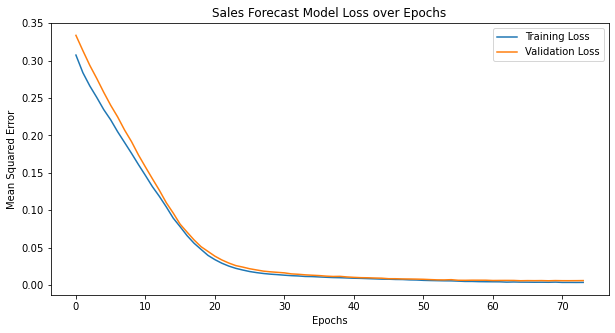

In [41]:
plt.figure(figsize=(10,5))
plt.plot(metrics_df.index, metrics_df.loss)
plt.plot(metrics_df.index, metrics_df.val_loss)
plt.title('Sales Forecast Model Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

In [42]:
lstm_pred = model.predict(X_test_lstm, batch_size=1)

In [43]:
lstm_pred = lstm_pred.reshape(-1,1)
lstm_pred_test_set = np.concatenate([lstm_pred,X_test], axis=1)
lstm_pred_test_set = scaler.inverse_transform(lstm_pred_test_set)

In [44]:
result_list = []
for index in range(0, len(lstm_pred_test_set)):
    result_list.append(lstm_pred_test_set[index][0] + act_sales[index])
lstm_pred_series = pd.Series(result_list, name='lstm_pred')
predict_df = predict_df.merge(lstm_pred_series, left_index=True, right_index=True)

In [45]:
lstm_rmse = np.sqrt(mean_squared_error(predict_df['lstm_pred'], monthly_sales['sales'][-12:]))
lstm_mae = mean_absolute_error(predict_df['lstm_pred'], monthly_sales['sales'][-12:])
lstm_r2 = r2_score(predict_df['lstm_pred'], monthly_sales['sales'][-12:])
print('LSTM RMSE: ', lstm_rmse)
print('LSTM MAE: ', lstm_mae)
print('LSTM R2 Score: ', lstm_r2)

LSTM RMSE:  15494.296868853291
LSTM MAE:  12533.464960899204
LSTM R2 Score:  0.9911825545326522


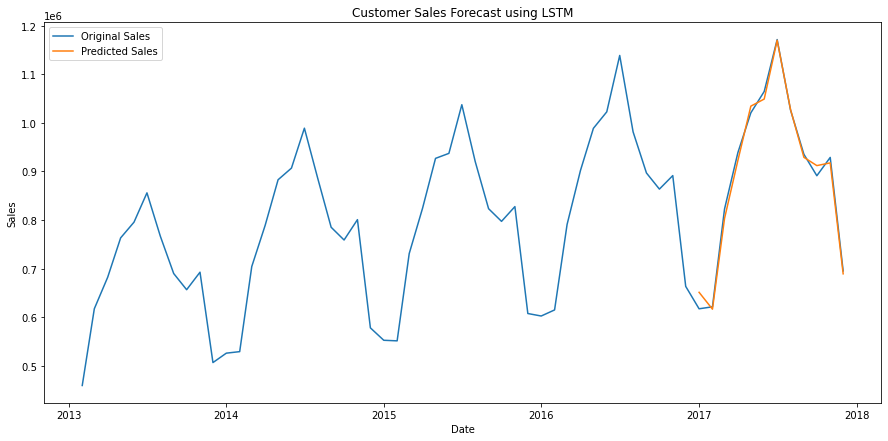

In [46]:
plt.figure(figsize=(15,7))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.plot(predict_df['date'], predict_df['lstm_pred'])
plt.title("Customer Sales Forecast using LSTM")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(["Original Sales", "Predicted Sales"])
plt.show()

#### Comparing Linear Regression, Random Forest, XG Boost, LSTM

In [47]:
linreg_stats = [linreg_rmse, linreg_mae, linreg_r2]
rf_stats = [rf_rmse, rf_mae, rf_r2]
xgb_stats = [xgb_rmse, xgb_mae, xgb_r2]
lstm_stats = [lstm_rmse, lstm_mae, lstm_r2]

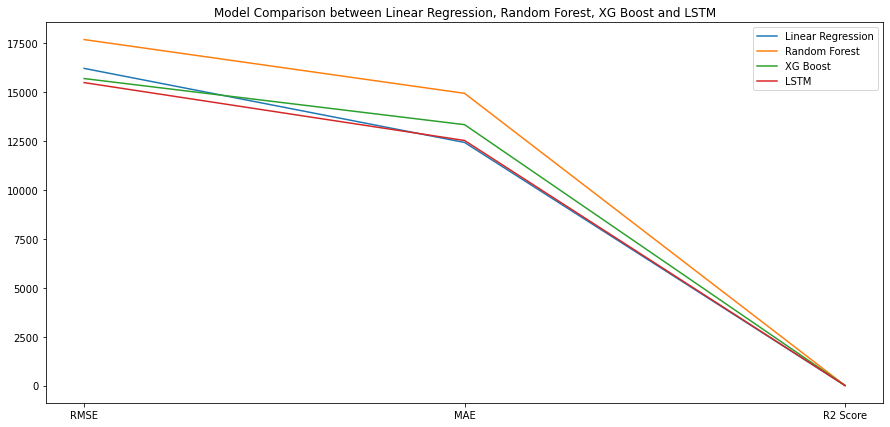

In [48]:
plt.figure(figsize=(15,7))
plt.plot(linreg_stats)
plt.plot(rf_stats)
plt.plot(xgb_stats)
plt.plot(lstm_stats)
plt.title("Model Comparison between Linear Regression, Random Forest, XG Boost and LSTM")
plt.xticks([0,1,2], labels=['RMSE','MAE','R2 Score'])
plt.legend(["Linear Regression", "Random Forest", "XG Boost", "LSTM"])
plt.show()